In [1]:
# %matplotlib notebook
%matplotlib inline
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader

import matplotlib.pyplot as plt
import numpy as np


In [2]:
#Define paramaters
EPOCHS = 300
LEARNING_RATE = 1e-2
LOG_INTERVAL = 50

BATCH_SIZE = 2
Z_DIMS = 64

VOXEL_SIZE = 64

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_path = '../../3d-mnist/voxels_3DMNIST_%s_train.npy' % VOXEL_SIZE
val_path = '../../3d-mnist/voxels_3DMNIST_%s_val.npy' % VOXEL_SIZE

In [4]:
def show_3d_sum(vol, axis=[0,1,2]):
    plt.figure(figsize=(20,20))
    for i in axis:
        img2d = np.sum(vol,axis=i)
        plt.subplot(1,3,i+1)
        plt.axis('off')
        plt.imshow(img2d)

In [5]:
def show_3d_interactive(vol):
    x, y, z = np.indices((16,16,16))

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(vol)
    plt.show()

In [6]:
def threshold(nda,eps=0.1):
    nda[nda<eps]=0
    return nda

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
# #         torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    elif isinstance(m, nn.Conv3d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [8]:
#Make dataset and dataloader
class VoxMnistDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data = np.load(data_path)
        #add 1 channels  #TODO as transform
        self.data = self.data[:,np.newaxis,:,:,:]
        self.data = self.data[:]
        print('self.data',self.data.shape)
        self.transform = transform
        # Get only the mask
        self.data = np.clip(self.data,0,1)  #
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        sample = torch.tensor(sample).float()
        if self.transform is not None:
            sample = self.transform(sample)  
        
        return sample#.unsqueeze(0)

In [9]:
transform = None

train_set = VoxMnistDataset(train_path,transform=transform)
print('train len',len(train_set))
val_set = VoxMnistDataset(val_path,transform=transform)
print('val len', len(val_set))

self.data (1, 1, 64, 64, 64)
train len 1
self.data (1, 1, 64, 64, 64)
val len 1


In [10]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False) #True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False) #True)
N_batch_train = len(train_loader)
N_batch_val = len(val_loader)

In [11]:
x = next(iter(train_loader))
print(type(x))
print('BATCH SIZE',x.size())

x = x[0]
print('SAMPLE SIZE',x.size())
print('MAX',np.max(x.numpy()))
print('SUM',np.sum(x.numpy()))
print(np.unique(x.numpy()))
del x

<class 'torch.Tensor'>
BATCH SIZE torch.Size([1, 1, 64, 64, 64])
SAMPLE SIZE torch.Size([1, 64, 64, 64])
MAX 1.0
SUM 10890.0
[0. 1.]


In [12]:
def loss_function(recon_x, x, mu, logvar):
    #measure of how well reconstruction matches input
    BCE = F.binary_cross_entropy(recon_x, x)
    #measure of distance btw learned distribution and Normal Gaussian
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= BATCH_SIZE * 16*16*16
    return BCE + KLD

In [13]:
from vae64 import Vae64 as VAE
#Instatiate network and optimizer
model = VAE().to(device)

# model.apply(init_weights)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)

Vae64(
  (relu): ReLU()
  (conv1): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2))
  (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv3): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2))
  (conv4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv5): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2))
  (conv6): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (conv7): Conv3d(64, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (fc_mu): Linear(in_features=27, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=27, out_features=64, bias=True)
  (upconv1): ConvTranspose3d(1, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2))
  (upconv2): ConvTranspose3d(64, 64, kernel_size=(4, 4, 4), stride=(1, 1, 1))
  (upconv3): ConvTranspose3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2))
  (upconv4): ConvTranspose3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (upconv5): ConvTranspose3d(16, 16, kernel_size=(4, 4, 4), stride=(2,

In [14]:
def train(epoch):
    model.train()
    train_loss = 0
    loss_history = list()
    
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            loss_history.append(loss.item())
            
    print('====> Epoch: {} Average loss: {:.5f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    return loss_history

def test(epoch):
    model.eval()
    test_loss = 0
    loss_history = list()
    # each data is BATCH_SIZE samples
    with torch.no_grad():
        for i, data in enumerate(val_loader): 
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(val_loader.dataset)
    loss_history.append(test_loss)

    print('====> Test set loss: {:.5f}'.format(test_loss))
    return loss_history

In [15]:
import time
train_loss_history = list()
test_loss_history = list()
for epoch in range(1, EPOCHS + 1):
    start = time.time()
    hist = train(epoch)    ## TRAIN
    train_loss_history.extend(hist)
    end = time.time()
    print('Training time for epoch: {:.2f}s'.format(end-start))
    hist = test(epoch)
    test_loss_history.extend(hist)
        
    print('======================================================')

Train Epoch: 1 [0/1 (0%)]	Loss: 0.687578
====> Epoch: 1 Average loss: 0.68758
Training time for epoch: 1.00s
====> Test set loss: 0.52729
Train Epoch: 2 [0/1 (0%)]	Loss: 0.537658
====> Epoch: 2 Average loss: 0.53766
Training time for epoch: 0.10s
====> Test set loss: 0.78903
Train Epoch: 3 [0/1 (0%)]	Loss: 1.018651
====> Epoch: 3 Average loss: 1.01865
Training time for epoch: 0.11s
====> Test set loss: 0.79412
Train Epoch: 4 [0/1 (0%)]	Loss: 1.012809
====> Epoch: 4 Average loss: 1.01281
Training time for epoch: 0.10s
====> Test set loss: 0.78852
Train Epoch: 5 [0/1 (0%)]	Loss: 1.006671
====> Epoch: 5 Average loss: 1.00667
Training time for epoch: 0.10s
====> Test set loss: 0.78614
Train Epoch: 6 [0/1 (0%)]	Loss: 0.994277
====> Epoch: 6 Average loss: 0.99428
Training time for epoch: 0.10s
====> Test set loss: 0.76885
Train Epoch: 7 [0/1 (0%)]	Loss: 0.953073
====> Epoch: 7 Average loss: 0.95307
Training time for epoch: 0.10s
====> Test set loss: 0.72428
Train Epoch: 8 [0/1 (0%)]	Loss: 0.

Train Epoch: 45 [0/1 (0%)]	Loss: 0.107492
====> Epoch: 45 Average loss: 0.10749
Training time for epoch: 0.10s
====> Test set loss: 0.16311
Train Epoch: 46 [0/1 (0%)]	Loss: 0.107639
====> Epoch: 46 Average loss: 0.10764
Training time for epoch: 0.10s
====> Test set loss: 0.17015
Train Epoch: 47 [0/1 (0%)]	Loss: 0.105981
====> Epoch: 47 Average loss: 0.10598
Training time for epoch: 0.09s
====> Test set loss: 0.18003
Train Epoch: 48 [0/1 (0%)]	Loss: 0.104874
====> Epoch: 48 Average loss: 0.10487
Training time for epoch: 0.11s
====> Test set loss: 0.17786
Train Epoch: 49 [0/1 (0%)]	Loss: 0.103677
====> Epoch: 49 Average loss: 0.10368
Training time for epoch: 0.09s
====> Test set loss: 0.19069
Train Epoch: 50 [0/1 (0%)]	Loss: 0.103400
====> Epoch: 50 Average loss: 0.10340
Training time for epoch: 0.10s
====> Test set loss: 0.20701
Train Epoch: 51 [0/1 (0%)]	Loss: 0.102356
====> Epoch: 51 Average loss: 0.10236
Training time for epoch: 0.10s
====> Test set loss: 0.20424
Train Epoch: 52 [0/1

Train Epoch: 89 [0/1 (0%)]	Loss: 0.084053
====> Epoch: 89 Average loss: 0.08405
Training time for epoch: 0.10s
====> Test set loss: 0.25910
Train Epoch: 90 [0/1 (0%)]	Loss: 0.084840
====> Epoch: 90 Average loss: 0.08484
Training time for epoch: 0.10s
====> Test set loss: 0.25866
Train Epoch: 91 [0/1 (0%)]	Loss: 0.083217
====> Epoch: 91 Average loss: 0.08322
Training time for epoch: 0.10s
====> Test set loss: 0.26439
Train Epoch: 92 [0/1 (0%)]	Loss: 0.082952
====> Epoch: 92 Average loss: 0.08295
Training time for epoch: 0.10s
====> Test set loss: 0.27050
Train Epoch: 93 [0/1 (0%)]	Loss: 0.082713
====> Epoch: 93 Average loss: 0.08271
Training time for epoch: 0.10s
====> Test set loss: 0.26532
Train Epoch: 94 [0/1 (0%)]	Loss: 0.083625
====> Epoch: 94 Average loss: 0.08362
Training time for epoch: 0.10s
====> Test set loss: 0.27982
Train Epoch: 95 [0/1 (0%)]	Loss: 0.082086
====> Epoch: 95 Average loss: 0.08209
Training time for epoch: 0.10s
====> Test set loss: 0.27274
Train Epoch: 96 [0/1

Train Epoch: 131 [0/1 (0%)]	Loss: 0.067708
====> Epoch: 131 Average loss: 0.06771
Training time for epoch: 0.10s
====> Test set loss: 0.32832
Train Epoch: 132 [0/1 (0%)]	Loss: 0.067848
====> Epoch: 132 Average loss: 0.06785
Training time for epoch: 0.10s
====> Test set loss: 0.34429
Train Epoch: 133 [0/1 (0%)]	Loss: 0.068502
====> Epoch: 133 Average loss: 0.06850
Training time for epoch: 0.10s
====> Test set loss: 0.34287
Train Epoch: 134 [0/1 (0%)]	Loss: 0.067872
====> Epoch: 134 Average loss: 0.06787
Training time for epoch: 0.10s
====> Test set loss: 0.33771
Train Epoch: 135 [0/1 (0%)]	Loss: 0.067228
====> Epoch: 135 Average loss: 0.06723
Training time for epoch: 0.10s
====> Test set loss: 0.34124
Train Epoch: 136 [0/1 (0%)]	Loss: 0.065910
====> Epoch: 136 Average loss: 0.06591
Training time for epoch: 0.10s
====> Test set loss: 0.33925
Train Epoch: 137 [0/1 (0%)]	Loss: 0.065859
====> Epoch: 137 Average loss: 0.06586
Training time for epoch: 0.09s
====> Test set loss: 0.33557
Train 

Train Epoch: 173 [0/1 (0%)]	Loss: 0.053590
====> Epoch: 173 Average loss: 0.05359
Training time for epoch: 0.12s
====> Test set loss: 0.37333
Train Epoch: 174 [0/1 (0%)]	Loss: 0.056867
====> Epoch: 174 Average loss: 0.05687
Training time for epoch: 0.10s
====> Test set loss: 0.38425
Train Epoch: 175 [0/1 (0%)]	Loss: 0.053355
====> Epoch: 175 Average loss: 0.05335
Training time for epoch: 0.10s
====> Test set loss: 0.38800
Train Epoch: 176 [0/1 (0%)]	Loss: 0.053053
====> Epoch: 176 Average loss: 0.05305
Training time for epoch: 0.10s
====> Test set loss: 0.36696
Train Epoch: 177 [0/1 (0%)]	Loss: 0.056163
====> Epoch: 177 Average loss: 0.05616
Training time for epoch: 0.10s
====> Test set loss: 0.37147
Train Epoch: 178 [0/1 (0%)]	Loss: 0.052705
====> Epoch: 178 Average loss: 0.05271
Training time for epoch: 0.10s
====> Test set loss: 0.38079
Train Epoch: 179 [0/1 (0%)]	Loss: 0.053997
====> Epoch: 179 Average loss: 0.05400
Training time for epoch: 0.12s
====> Test set loss: 0.38002
Train 

Train Epoch: 215 [0/1 (0%)]	Loss: 0.041636
====> Epoch: 215 Average loss: 0.04164
Training time for epoch: 0.10s
====> Test set loss: 0.41163
Train Epoch: 216 [0/1 (0%)]	Loss: 0.044425
====> Epoch: 216 Average loss: 0.04443
Training time for epoch: 0.09s
====> Test set loss: 0.41206
Train Epoch: 217 [0/1 (0%)]	Loss: 0.041274
====> Epoch: 217 Average loss: 0.04127
Training time for epoch: 0.11s
====> Test set loss: 0.40967
Train Epoch: 218 [0/1 (0%)]	Loss: 0.044957
====> Epoch: 218 Average loss: 0.04496
Training time for epoch: 0.09s
====> Test set loss: 0.42239
Train Epoch: 219 [0/1 (0%)]	Loss: 0.050371
====> Epoch: 219 Average loss: 0.05037
Training time for epoch: 0.11s
====> Test set loss: 0.40557
Train Epoch: 220 [0/1 (0%)]	Loss: 0.038728
====> Epoch: 220 Average loss: 0.03873
Training time for epoch: 0.09s
====> Test set loss: 0.40895
Train Epoch: 221 [0/1 (0%)]	Loss: 0.044542
====> Epoch: 221 Average loss: 0.04454
Training time for epoch: 0.11s
====> Test set loss: 0.41781
Train 

Train Epoch: 258 [0/1 (0%)]	Loss: 0.032847
====> Epoch: 258 Average loss: 0.03285
Training time for epoch: 0.11s
====> Test set loss: 0.45843
Train Epoch: 259 [0/1 (0%)]	Loss: 0.030288
====> Epoch: 259 Average loss: 0.03029
Training time for epoch: 0.11s
====> Test set loss: 0.46076
Train Epoch: 260 [0/1 (0%)]	Loss: 0.033952
====> Epoch: 260 Average loss: 0.03395
Training time for epoch: 0.10s
====> Test set loss: 0.47192
Train Epoch: 261 [0/1 (0%)]	Loss: 0.032323
====> Epoch: 261 Average loss: 0.03232
Training time for epoch: 0.11s
====> Test set loss: 0.48876
Train Epoch: 262 [0/1 (0%)]	Loss: 0.029529
====> Epoch: 262 Average loss: 0.02953
Training time for epoch: 0.09s
====> Test set loss: 0.50011
Train Epoch: 263 [0/1 (0%)]	Loss: 0.027544
====> Epoch: 263 Average loss: 0.02754
Training time for epoch: 0.09s
====> Test set loss: 0.49174
Train Epoch: 264 [0/1 (0%)]	Loss: 0.029669
====> Epoch: 264 Average loss: 0.02967
Training time for epoch: 0.09s
====> Test set loss: 0.47063
Train 

Train Epoch: 300 [0/1 (0%)]	Loss: 0.036845
====> Epoch: 300 Average loss: 0.03684
Training time for epoch: 0.09s
====> Test set loss: 0.47342


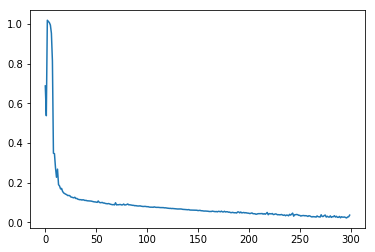

In [16]:
plt.plot(train_loss_history[:])

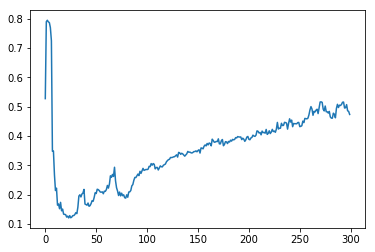

In [17]:
plt.plot(test_loss_history[:])

(64, 64, 64)
(64, 64, 64)


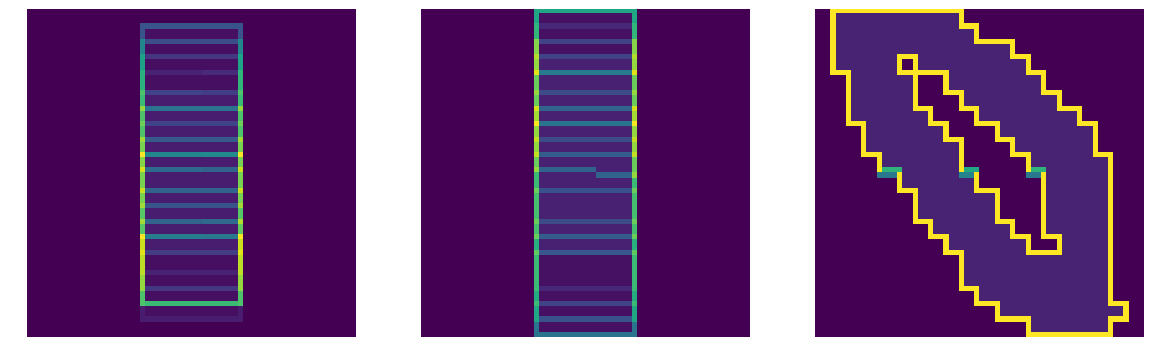

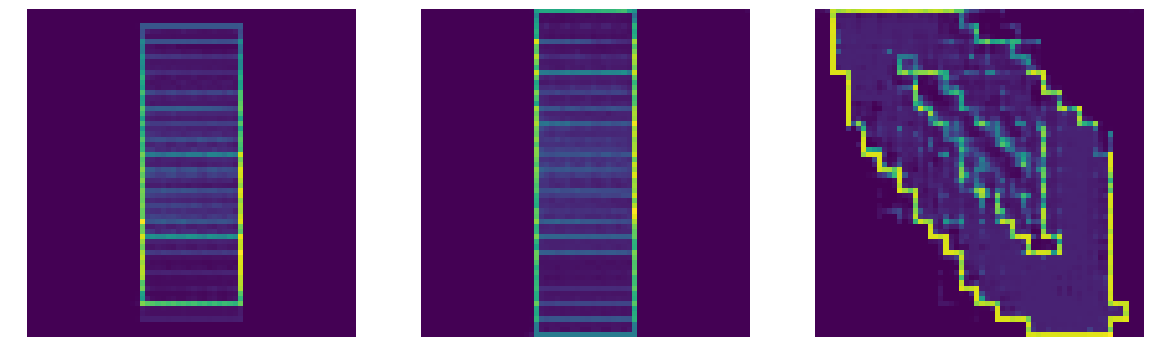

In [18]:
#Check reconstruction for a sample
idx = 0
with torch.no_grad():
    model.eval()
    batch = torch.tensor(train_set[idx]).unsqueeze(0).to(device)    
    batch_recon, mu, logvar = model(batch)

i=0
s = np.squeeze(batch[i].cpu().numpy())
s_recon = np.squeeze(batch_recon[i].cpu().numpy())
# use np.round(s_recon) to get it as a mask
print(s.shape)
print(s_recon.shape)

show_3d_sum(s)
show_3d_sum(s_recon)

Generating samples


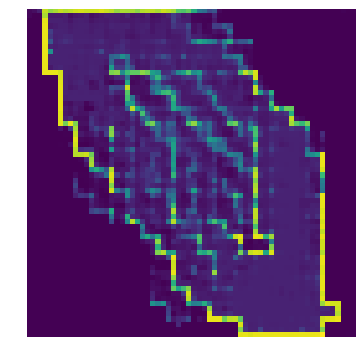

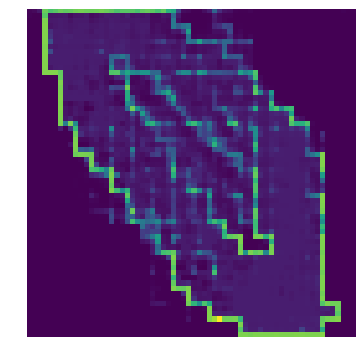

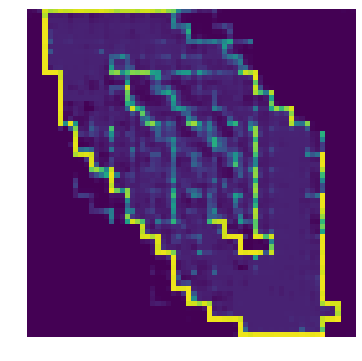

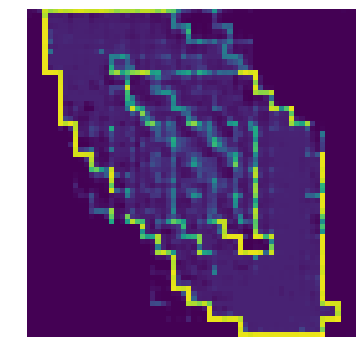

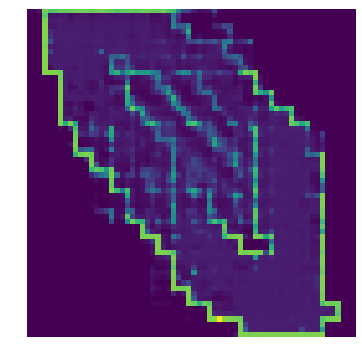

In [19]:
print('Generating samples')
N_samples = 5
with torch.no_grad():
    z_samples = torch.randn(N_samples, Z_DIMS).to(device)
    samples = model.decode(z_samples).cpu().numpy()
        
for x in samples:
    show_3d_sum(x.squeeze(),[2])

In [20]:
## Latent space visualization for Z_DIMS=2
if Z_DIMS==2:
    with torch.no_grad():
        nn = 10
        zs = np.array([(z1, z2)
                       for z1 in np.linspace(-2, 2, nn)
                       for z2 in np.linspace(-2, 2, nn)]).astype('float32')
        xs = model.decode(torch.tensor(zs).to(device))
        print(xs.size())
        xs = xs.cpu().numpy()
        xs = xs[:,0,:,:,:] #remove unidimension for the channel
        print(xs.shape)

    xs_mat = np.bmat([[np.sum(xs[i + j * nn],axis=2) for i in range(nn)] for j in range(nn)])
    print(xs_mat.shape)
    
    from matplotlib import rc
    rc('axes', **{'grid': False})
    plt.figure(figsize=(10, 10))
    plt.imshow(xs_mat, interpolation='none')
    plt.show()